# PART D)
### Altering my code to accept another parameter to account for point sources in the field

### This is *very* similar to the previous script, but I changed a couple important things to allow for the new parameter.  

### If you search for  !!!   you can see where I made changes or report differing results.

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import camb
import corner as cp
import time
import os

In [3]:
wmap_data = np.genfromtxt("wmap_tt_spectrum_9yr_v5.txt")
ell = wmap_data[:,0]
tt = wmap_data[:,1]
tterr = wmap_data[:,2]


In [7]:
# just alter max_l to run faster
pars=camb.CAMBparams()
pars.set_for_lmax(1250)
print("max_l:",pars.max_l)
## I checked, this only changes chi^2 by ~0.03


max_l: 1400



Getting the MCMC code in shape

First we define a bunch of helper functions that will allow the MCMC function to run.  These are, of course, very similar to the ones we set up in class.  I have altered a few though.

In [8]:
def calc_chi2(wmap_data,modelPS):
    """
    Return chi^2 given a set of TT power spectrum data and a model TT power spectrum
    """
    ell = np.asarray(wmap_data[:,0],dtype='int') #first column is ell
    delta = wmap_data[:,1] - modelPS#[ell]        #next column is TT power spectrum
    chi2 = np.sum( (delta/wmap_data[:,2])**2)    #third column is err of TT
    return chi2

def update_model(cosmology,pars):
    """
    Having chosen a new cosmology, we need camb to update the pars
    """
    pars2 = pars.copy()
    pars2.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],H0=cosmology[3],tau=cosmology[5])
    pars2.InitPower.set_params(As=cosmology[2],ns=cosmology[4])
    return pars2
    
def get_power_spectrum(cosmology,pars):
    """
    With new input cosmology, update pars and make a new power spectrum
    """
    pars2 = update_model(cosmology,pars)
    results = camb.get_results(pars2)
    modelPS = results.get_cmb_power_spectra(pars2,CMB_unit='muK')['total']
    return modelPS

def get_chi2_from_cosmology(cosmology,wmap_data,pars):
    """
    For input cosmology, we build a power spectrum, then calculate the chi^2 of
    the data against that model
    
    !!! UPDATE -- added point source term to model power spectrum
    """
    a_src = cosmology[6]
    ell = np.asarray(wmap_data[:,0],dtype='int')
    modelPS=get_power_spectrum(cosmology,pars)[ell]
    modelPS=modelPS[:,0] + a_src*ell**2  # only want TT powspec with point source term added
    chi2 = calc_chi2(wmap_data,modelPS)
    return chi2


def get_step(step_size):
    """
    Take gaussian steps with std dev according to step_size
    """
    return np.random.randn(len(step_size))*step_size*scale_steps


def get_cov_step(mat,nset=1):
    """
    Based on the HW2 problem.  Given a covariance matrix, produce a random step for each
    parameter with the same kind of correlation.
    """
    e,v=np.linalg.eigh(mat)
    e[e<0]=0 #make sure we don't have any negative eigenvalues due to roundoff
    n=len(e)
    #make gaussian random variables
    g=np.random.randn(n,nset)
    #now scale them by the square root of the eigenvalues
    rte=np.sqrt(e)
    # This loop was for the general case of requesting mulitple samples.
    # I'm only ever asking for 1 here  (I tried removing it and formatting went funny, so I kept it)
    for i in range(nset):
        g[:,i]=g[:,i]*rte
    #and rotate back into the original space
    dat=np.dot(v,g).reshape((1,n)) * scale_steps
    return dat[0]

def get_cov_step_6of7params(mat,nset=1):
    """
    !!! UPDATE
    This is the same as get_cov_step() above, but the provided cov_matrix only has the first
    six parameters.  The 7th (a_src) is just a gaussian step.
    """
    e,v=np.linalg.eigh(mat)
    e[e<0]=0
    n=len(e)
    g=np.random.randn(n,nset)
    rte=np.sqrt(e)
    for i in range(nset):
        g[:,i]=g[:,i]*rte
    # steps for first 6 params (covariant)
    steps1to6=(np.dot(v,g).reshape((1,n)) * scale_steps[:6])[0]
    # step for the final param (gaussian)
    step7= np.random.randn(1)*step_size[6]*scale_steps[6]
    return np.append(steps1to6,step7)


"""
Redefine cosmology as cosmology with a_src appended
"""


def MCMC(cosmology,wmap_data,pars,step_size,outfile,nstep=100,printind=0,cov_mat=None):
    """
    !!! UPDATE -- added point source parameter to end of cosmology
               -- also MCMC decides how to take steps based on input covariance matrix
    Runs the MCMC chain.
    Requires as inputs:
        1) initial guess cosmology: ([Obh2, Och2, As, h0, ns, tau, a_src])
        2) wmap data set (1st col = ell, 2nd col = TT, 3rd col = err(TT))
        3) camb pars that match initial cosmology guess
        4) step size (std dev of gaussian steps for each cosmology parameter)
        5) **optional** number of steps (default 100 if not specified)
        6) **optional** index of chain parameter to print out in real time
        7) **optional** covariance matrix of chain parameters.  If "None" it will
              take steps based on step_size input
    """
    
    if cov_mat is not None: print("--Using covariant steps--")
    print("Steps scaled by:",scale_steps)
    naccept=0
    chain = np.zeros([nstep,len(cosmology)+1])
    chi2_now = get_chi2_from_cosmology(cosmology, wmap_data, pars)
    for iter in range(nstep):
        # depending on what kind of covariance matrix is input, take different steps
        if cov_mat is not None:
            if len(cov_mat)==7:
                new_cosmology = cosmology + get_cov_step(cov_mat)
            elif len(cov_mat)==6:
                new_cosmology = cosmology + get_cov_step_6of7params(cov_mat)
            else: print("Covariance matrix is wrong shape")
        else:
            new_cosmology = cosmology + get_step(step_size)
            
        new_chi2 = get_chi2_from_cosmology(new_cosmology,wmap_data,pars)
        
        like = np.exp(-0.5*(new_chi2-chi2_now))
        accept = np.random.rand()<like
        
        # don't accept negative tau values
        if new_cosmology[5]<0: 
            accept=False
            print("    --> Rejected for negative tau")
        # don't accept negative a_src values
        if new_cosmology[6]<0: 
            accept=False
            print("    --> Rejected for negative a_src")
            
        print("%4i, %12.5f, %12.5f, %6s, %12.4e, %10.3e, %7.3f"%(iter,chi2_now,new_chi2,accept,new_cosmology[printind],like,naccept/(iter+1)))
        
        if accept:
            cosmology = new_cosmology
            chi2_now = new_chi2
            naccept+=1
        
        chain[iter,0] = chi2_now
        chain[iter,1:]= cosmology
        
        # this will feed into file in real-time rather than waiting to finish chain
        datastring = "%12.5e %12.5e %12.5e %12.5e %12.5e %12.5e %12.5e %12.5e"%tuple(chain[iter,:])
        commandstring = 'echo "%s" >> %s'%(datastring,outfile) 
        os.system(commandstring)
        
    frac_accept=naccept/nstep
    print("Accepted %.1f percent of steps"%(frac_accept*100))
    return chain,frac_accept
        
        
        
        

This next segment takes in a small test chain that varies only one cosmology parameter (I did 20 iters) and finds the 1D curvature.  I use this to find the minimum $\chi^2$ and estimate of the error ($1/\sqrt{a}$ where $a$ is the quadratic coefficient fit to the 1D $\chi^2$ surface).  Results are the 6 figures labeled "B\_param#\_1d\_curvature.png".

In [36]:
# which param in cosmology are we going to explore
#  (counting from 1, not zero because chi^2 takes up 0th index later)
index = 7

# !!! explore extra parameter in 1D

#cosmology0 = np.asarray([0.02237,0.1112,1.1e-9,71.2,0.9674,0.086])
cosmology0 = np.asarray([ 2.26e-02, 1.10e-01, 2.08e-09, 7.20e+01, 9.73e-01, 6.61e-02, 2.335e-5]) #good chi2 
pars = camb.CAMBparams()
step_size=np.asarray([0,0,0,0,0,0,3.5e-5])# just looking at one at a time for now
scale_steps=np.ones([7])
nstep=30

outfile="testchain_param7.txt"

print("   i      old X^2       new X^2   accept      value     likelihood  frac accept")
chain,f_accept = MCMC(cosmology0,wmap_data,pars,step_size,outfile,nstep=nstep,printind=index-1,cov_mat=None)


#chain indices: [ chi2, Obh2, Och2, As, h0, ns, tau, a_src ]

"""
Record values that I find are good for initial guess and step size:

cosmology0 = np.asarray([2.33e-2, 0.11583, 2.09e-9,  65.8, 0.971,   0.0674])
step_size  = np.asarray([2.31e-4, 7.76e-4, 7.63e-12, 0.66, 4.92e-3, 1.84e-3])
"""

   i      old X^2       new X^2   accept      value     likelihood  frac accept
Steps scaled by: [1. 1. 1. 1. 1. 1. 1.]
   0,   1230.57157,   1232.75488,  False,  -2.8710e-05,  3.357e-01,   0.000
   1,   1230.57157,   1233.46623,  False,   8.3540e-05,  2.352e-01,   0.000
   2,   1230.57157,   1231.77345,  False,   6.2175e-05,  5.483e-01,   0.000
   3,   1230.57157,   1230.59179,   True,   1.8442e-05,  9.899e-01,   0.000
   4,   1230.59179,   1230.62453,   True,   1.5338e-05,  9.838e-01,   0.200
   5,   1230.62453,   1231.38651,  False,   5.5340e-05,  6.832e-01,   0.333
   6,   1230.62453,   1230.68473,   True,   1.1586e-05,  9.703e-01,   0.286
   7,   1230.68473,   1230.92618,   True,   4.4491e-05,  8.863e-01,   0.375
   8,   1230.92618,   1230.58365,   True,   1.9581e-05,  1.187e+00,   0.444
   9,   1230.58365,   1230.73329,   True,   3.7665e-05,  9.279e-01,   0.500
  10,   1230.73329,   1230.64156,   True,   3.2807e-05,  1.047e+00,   0.545
  11,   1230.64156,   1234.96817,  False,   

'\nRecord values that I find are good for initial guess and step size:\n\ncosmology0 = np.asarray([2.33e-2, 0.11583, 2.09e-9,  65.8, 0.971,   0.0674])\nstep_size  = np.asarray([2.31e-4, 7.76e-4, 7.63e-12, 0.66, 4.92e-3, 1.84e-3])\n'

Optimization terminated successfully.
         Current function value: 1230.571585
         Iterations: 8
         Function evaluations: 16


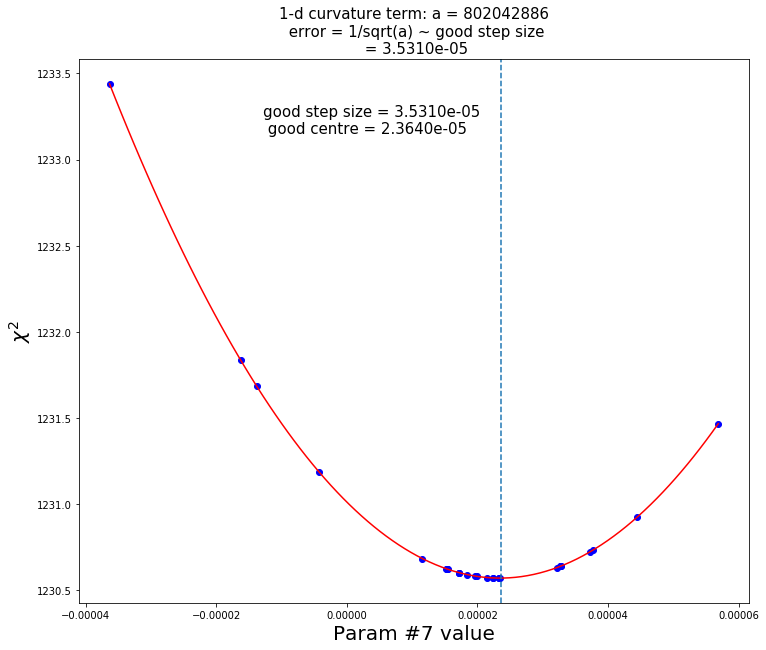

In [37]:
def quad(x):
    return p[0]*x**2+p[1]*x+p[2]

p=np.polyfit(chain[:,index],chain[:,0],2)
x=np.linspace(min(chain[:,index]),max(chain[:,index]),100)
y=quad(x)

minimum = sp.optimize.fmin(quad, np.mean(x))

plt.figure(num=3,figsize=(12,10))
plt.clf()
plt.title("1-d curvature term: a = %.0f\n error = 1/sqrt(a) ~ good step size\n = %.4e"\
          %(p[0],1/np.sqrt(p[0])),fontsize=15)

plt.plot(chain[:,index],chain[:,0],'bo')
plt.plot(x,y,'r-')

ytext = np.max(y)-0.1*(np.max(y)-np.min(y))
plt.text(x[25],ytext,"good step size = %.4e \n good centre = %.4e"\
         %(1/np.sqrt(p[0]),minimum),fontsize=15)


plt.axvline(minimum,linestyle='--')

plt.xlabel("Param #"+str(index)+" value",fontsize=20)
plt.ylabel(r"$\chi^2$",fontsize=20)
plt.savefig("figures/B_param"+str(index)+"_1d_curvature.png")
plt.show()


Now that we have a decent idea of the initial guess and step sizes, lets run a short chain on all parameters.

In [10]:
# Covariance matrix
cov_chain = np.genfromtxt("chain_ALLparam_run8.txt")

cov = np.cov(cov_chain[:,1:].T)

print(np.shape(cov))


(6, 6)


In [20]:
"""
For non-covraiant steps:
       1.87 seconds per iter
    or 1930 iters per hour
       
overnight, run 9 hrs (10pm-7am) -->  iters
"""

""" RUNNING MCMC WILL ADD LINES TO BOTTOM OF FILE (or create new file if new name is given)"""

# !!! Include the extra parameter in the full 7D MCMC run

name="run12"
nsteps= 17000
cov_mat = cov
scale_steps = np.asarray([1.,1.,1.,1.,1.,1.,0.75])/1.5
index = 7 #print out value:  1=Obh2, 2=Och2, 3=As, 4=h0, 5=ns, 6=tau, 7=a_scr

loadchain=True; loadname=name
restart  =True; restartfrom=name

if loadchain==False:
    #  chi2 = 1.27e+03
    #cosmology0 = np.asarray([ 2.26e-02, 1.10e-01, 2.08e-09, 7.10e+01, 9.73e-01, 5.5e-02, 2.335e-5]) #good chi2 
    #  chi2 = 1.23e+03
    cosmology0 = np.asarray([ 2.30e-02, 1.02e-01, 2.55e-09, 7.48e+01, 9.94e-01, 1.82e-01, 3.51e-05])
    step_size = np.asarray([4e-4,    1.26e-3,  1e-11,   0.8,      7e-3,    2e-3,   3.5e-5])#run3

    if restart:
        lastchain = np.genfromtxt("chain_ALLparam_"+restartfrom+".txt")[-1]
        cosmology0=lastchain[1:]

        
    outfile="chain_ALLparam_"+name+".txt"
    
    start = time.time()
    print("   i      old X^2       new X^2   accept      value     likelihood  frac accept")
    chain,f_accept = MCMC(cosmology0,wmap_data,pars,step_size,outfile,nstep=nsteps,printind=index-1,cov_mat=cov_mat)
    end = time.time()
    print("Took %.1f seconds to run %i iters"%(end-start,nsteps))
    print("  i.e. %.2f seconds per iter"%((end-start)/nsteps))
    print("    or %.i iters per hour"%(3600/((end-start)/nsteps)))
    
else:
    chain = np.genfromtxt("chain_ALLparam_"+loadname+".txt")

    
#chain indices: [ chi2, Obh2, Och2, As, h0, ns, tau ]



In [ ]:
"""
Here I'm keeping track of values that I used in certain chain runs.  
Won't be very meaningful to you, the grader.


FROM 1D CURVATURE TESTS:
cosmology0 = np.asarray([2.33e-2, 0.11583, 2.09e-9,  65.8, 0.971,   0.0674])
step_size  = np.asarray([2.31e-4, 7.76e-4, 7.63e-12, 0.66, 4.92e-3, 1.84e-3])

AFTER SHORT FULL-PARAMETER MCMC
LOOKING AT SCATTER AROUND MEAN:
cosmology0 = np.asarray([2.225e-2, 0.114, 1.85e-9,  69.0,   0.97,   0.0674])
step_size  = np.asarray([5.97e-4, 5.27e-3, 3.62e-11, 2.59, 1.53e-2, 2.26e-02])
                                                                     ^might be too large...
BY EYE
step_size = np.asarray([4e-4, 1.26e-3, 1e-11, 0.8, 7e-3, 2e-3])
produces acceptance rate of ~0.189


run2:
    15,000 iters, tau was allowed negative

run3:
    16,000 iters , f_accept = 19%
    step_size = np.asarray([4e-4, 1.26e-3, 1e-11, 0.8, 7e-3, 2e-3])
    Obh2 - corr 750, chi2 is parabolic
    Och2 - corr 2300, chi2 is parabolic
    As   - corr 2000, chi2 looks quite random
    H0   - corr 2400, chi2 is parabolic
    ns   - corr 1400, chi2 is parabolic
    tau  - corr >2500, chi2 looks quite random
    
    --extending another 14,500 iters
    --extending yet another 14,500 iters

run4:
      -- increase step size for Och2(a bit), As(moderately), H0(a bit), tau(a lot)
    step_size = np.asarray([4e-4, 1.6e-3, 3e-11, 1.0, 7e-3, 1e-2])


run5:
    -- steps are generated from covariance matrix of run3
     (SOMETHING IS VERY WRONG HERE)
        +/- errors from cov cornerplot [5.77e-04 6.23e-03 8.90e-11 2.84e+00  1.56e-02  2.31e-02]

run6:
    -- steps are from run3 cov matrix, but scaled by 1/4
     - accepted close to 50%, some params veered way off expected values

run7:
    -- steps from run3 cov matrix, but scaled by 1/2

run8:
    -- cov matrix.  scaled by 0.5.  Chose a better starting point
    -- SEEMS GOOD!!
       (acceptance is a little high -61%- could maybe scale steps a little bigger)
         acceptance rate stabilizes by about 500 iters
   
run9:
    -- added 7th parameter, a_src
    -- running without covariant steps in order to build covariance matrix for 7-param chain
   
   
run10:
    --  Using steps: [4e-4, 1.26e-3, 1e-11, 0.8, 7e-3, 2e-3, 3.5e-5]* [1.,1.,1.,1.,1.,1.,0.6]
    --  a_src steps might still be too big since I'm getting a lot of rejections for negative a_src
    -- getting a retention of ~15%
    --  hopefully can build a cov matrix from this
    
run11:
    -- cov matrix. scaled by 1/2
    -- acceptance of ~21%
    -- Seem to be large covariances between parameters where there wasn't before...
    -- Chi^2 parabaloids aren't very well-defined
    
run12:
    -- use cov matrix for first 6 cosmo params.  Take gaussian step for a_src
    --    used run8 for cov matrix. scale by 1/1.5.  a_src step: 3.5e-5 * 0.75 / 1.5

some future run:
    -- cov matrix scaled by 1/1.5.  Go with good starting point
    -- set lmax to lower value (2500 -> 1300) should run faster
"""

This next block takes a look at the chain produced above. On the left side are plots of the chain values. On the right are the $\chi^2$ vs parameter plots.

/Applications/anaconda/envs/forjupyter3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


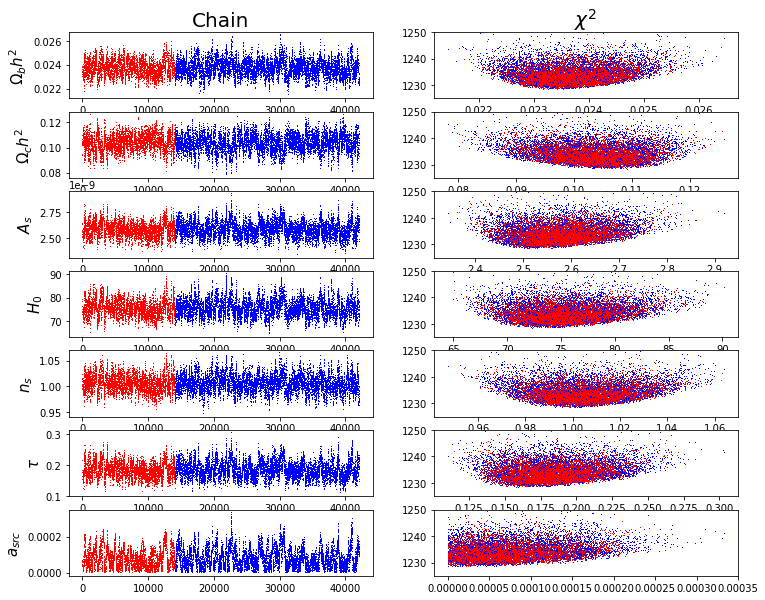

In [13]:
paramnames=[r"$\Omega_b h^2$",r"$\Omega_c h^2$", "$A_s$", "$H_0$", "$n_s$", r"$\tau$","$a_{src}$"]
nparams=len(paramnames)
plt.figure(figsize=(12,10))
plt.clf()
burn=np.int(len(chain[:,0])/3)
for i in np.arange(nparams)+1:
    chainvalues = chain[:,i]
    chi2values = chain[:,0]
    plt.subplot(nparams,2,2*i-1)
    plt.plot(chainvalues,'b,')
    plt.plot(chainvalues[:burn],'r,')
    plt.ylabel(paramnames[i-1],fontsize=15)
    #plt.xlim(6000,7000)
    plt.subplot(nparams,2,2*i)
    plt.plot(chainvalues,chain[:,0],'b,')
    plt.plot(chainvalues[:burn],chi2values[:burn],'r,')
    plt.ylim(1225,1250)

plt.subplot(nparams,2,1); plt.title("Chain",fontsize=20)
plt.subplot(nparams,2,2); plt.title(r"$\chi^2$",fontsize=20)
plt.savefig('figures/chain_overview_'+name+'.png')
plt.show()


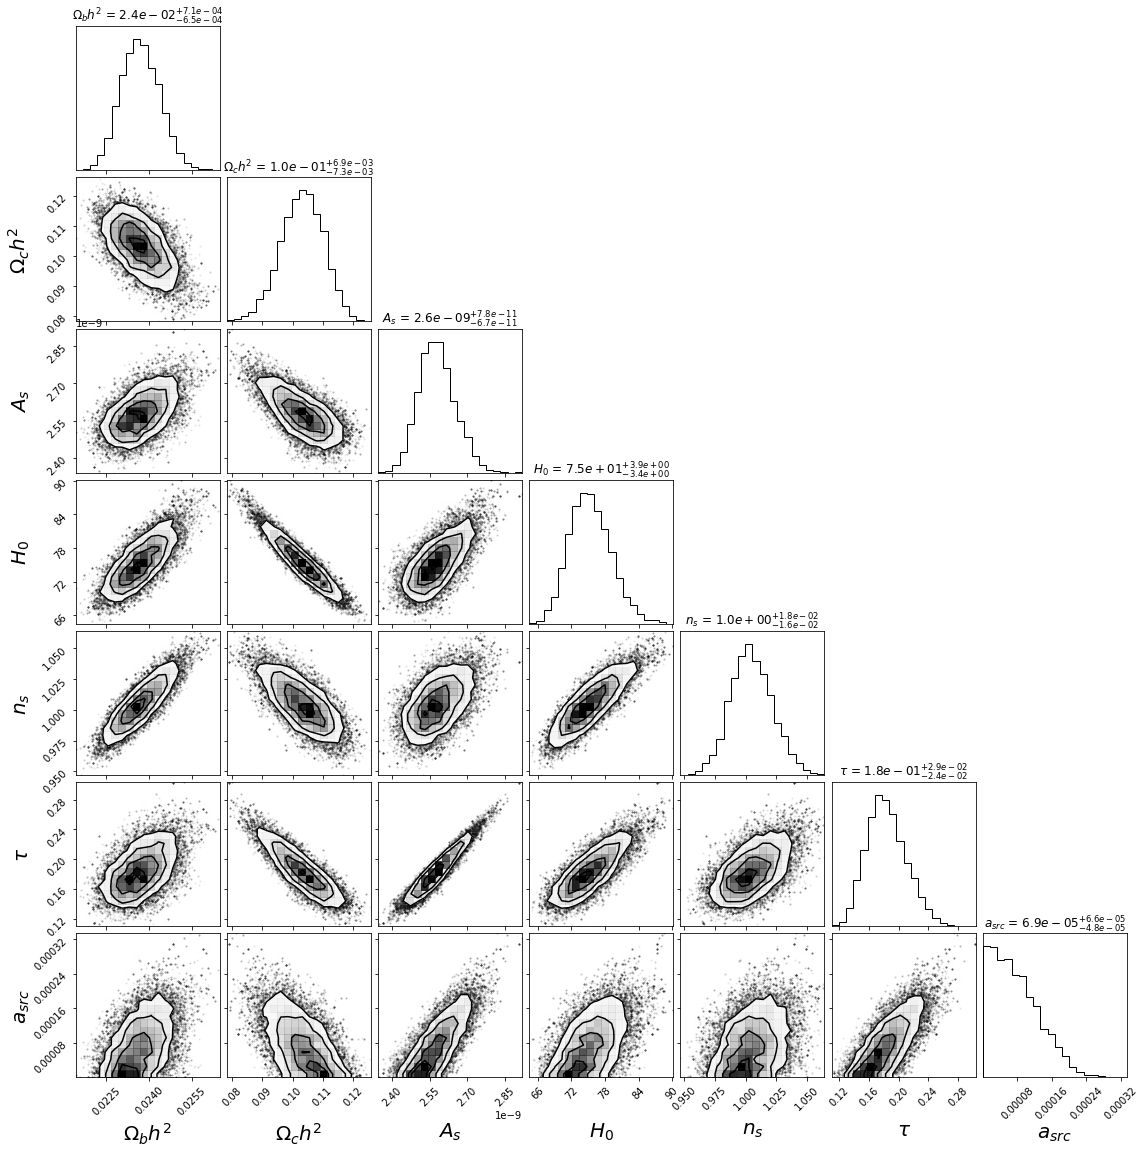

In [14]:
cornerplot = cp.corner(chain[:,1:],
                       labels=paramnames, label_kwargs={"fontsize": 20},
                       title_fmt='.1e',
                       show_titles=True, title_kwargs={"fontsize": 12} )

plt.savefig('figures/cornerplot_'+name+'.png')


## (!!!) Changes made by including the point source parameter.

(Comparing plots *cornerplot_run8.png* and *cornerplot_run12.png*)

#### It really seems that introducing the point source parameter $a_{src}$ has amplified some of the corrleations between different parameters.  In general, the plots seem less "globular" than before.  The general direction of the correlation has remained, but it seems like they are much more pronounced.

#### $H_0$ has come up a lot from 70 $\rightarrow$ 75

#### $\tau$ has also increased dramatically from 0.0058 $\rightarrow$ 0.018

Look at correlation length

/Applications/anaconda/envs/forjupyter3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


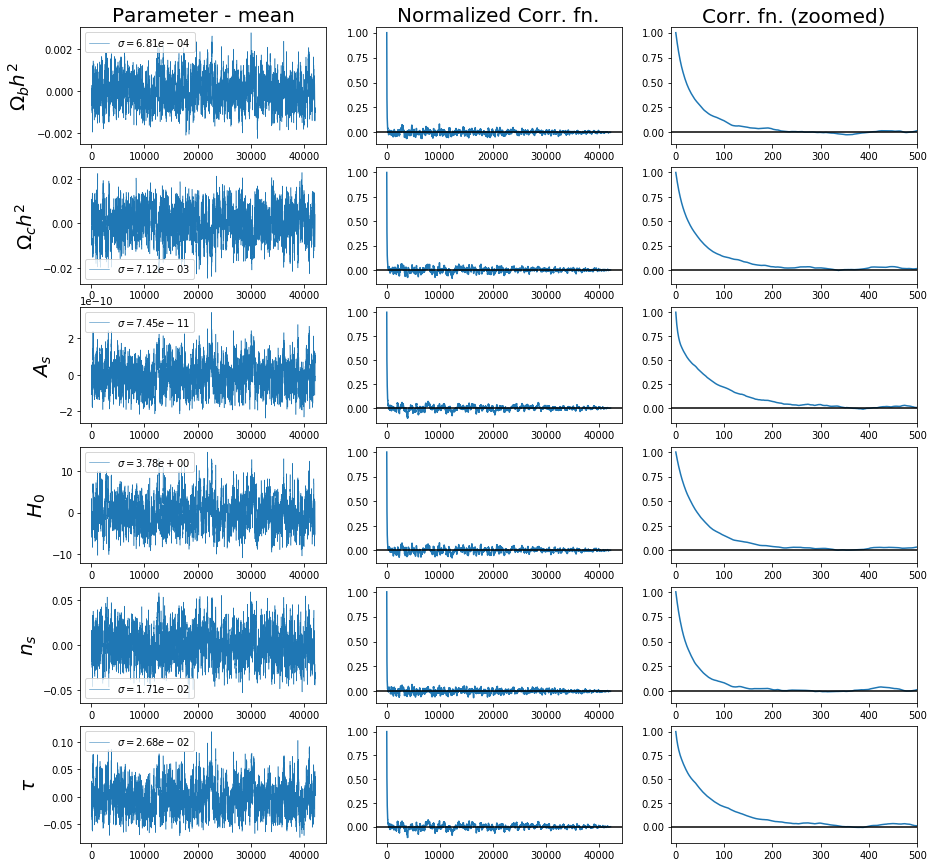

[6.80844823e-04 7.11801533e-03 7.45068854e-11 3.77568072e+00
 1.71154232e-02 2.68068379e-02]


In [15]:
def autocorr(f):
    n = len(f)
    ff = np.append(f,np.zeros(n))
    C = np.zeros(n)
    # I know there's a cleverer way to do this with fft's
    #   but I never got around to it.
    for i in range(n):
        C[i] = np.sum( f*ff[i:n+i] )
    return C/C[0]


plt.figure(figsize=(15,15))

new_step_size=np.zeros(6)

for i in range(6):
    
    paramchain = chain[:,i+1]
    n=len(paramchain)
    burn = np.int(n/3)
    paramchain = paramchain-np.mean(paramchain[burn:])

    corr = autocorr(paramchain)
    err = np.std(paramchain[burn:])
    new_step_size[i]=err
    
    plt.subplot(6,3,3*i+1)
    plt.plot(paramchain,lw=0.5,label="$\sigma=%.2e$"%(err))
    plt.ylabel(paramnames[i],fontsize=20)
    plt.legend()

    plt.subplot(6,3,3*i+2)
    plt.plot(corr)
    plt.axhline(0,color='k')

    plt.subplot(6,3,3*i+3)
    plt.plot(corr)
    plt.axhline(0,color='k')
    plt.xlim(-10,500)
    
plt.subplot(6,3,1);plt.title("Parameter - mean",fontsize=20)
plt.subplot(6,3,2);plt.title("Normalized Corr. fn.",fontsize=20)
plt.subplot(6,3,3);plt.title("Corr. fn. (zoomed)",fontsize=20)
plt.savefig('figures/corr_overview_'+name+'.png')
plt.show()
print(new_step_size)

# Best fit parameters:
 (Values and uncertainties can be seen in the corner plot)
### (!!!) What does this cosmology look like?

$\chi^2$ changed from 1228.083 (no point source) to 1228.542 (point source).  It has actually increased (though marginally) despite having an extra parameter to fit the data. Normally, I would imagine this tells us that there is not significant contamination by point sources... *however*, it did change some of the best-fit cosmology parameters by a fairly significant margin, so maybe they are important.

Best-fit Chi^2: 1228.542


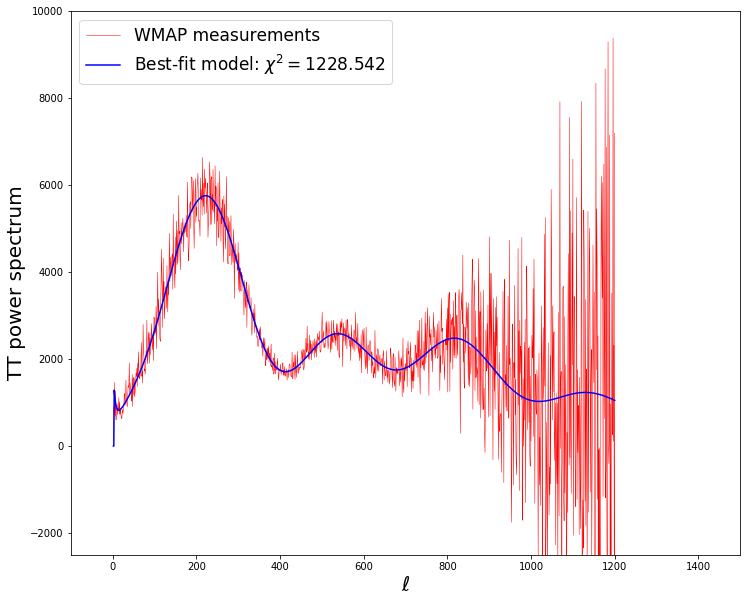

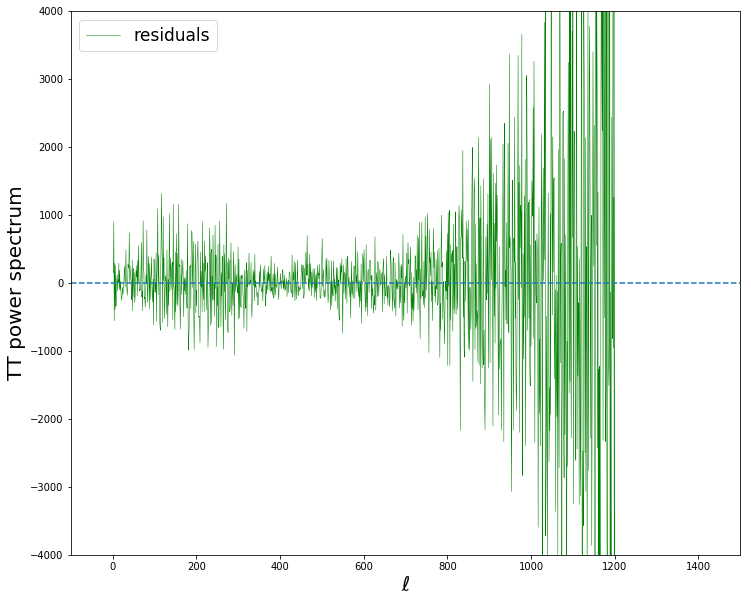

In [19]:
best_cosmo=np.zeros(7)
for i in range(7):
    best_cosmo[i] =  np.mean(chain[:,i+1])

pars=update_model(best_cosmo,pars)
results=camb.get_results(pars)
powspec=results.get_cmb_power_spectra(pars,CMB_unit='muK')['total'][:,0]
powspec=powspec[:len(tt)]
ell_model = np.arange(2,len(powspec)+2)

best_chi2 = get_chi2_from_cosmology(best_cosmo,wmap_data,pars)



plt.figure(figsize=(12,10))
plt.clf()

plt.plot(ell,tt,'r-',lw=0.5,label="WMAP measurements")
plt.plot(ell_model, powspec,'b-',label=r"Best-fit model: $\chi^2=%.3f$"%best_chi2)

plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel("TT power spectrum",fontsize=20)
plt.xlim(-100,1500)
plt.ylim(-2500,10000)
plt.legend(fontsize=17)
plt.show()



plt.figure(figsize=(12,10))
plt.clf()

plt.plot(ell,tt-powspec,'g-',lw=0.5,label="residuals")
plt.axhline(0,linestyle='--')

plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel("TT power spectrum",fontsize=20)
plt.xlim(-100,1500)
plt.ylim(-4000,4000)
plt.legend(fontsize=17)
plt.show()

NOTES:

try:
    - subtract mean when doing the covariance (I think np.cov did this)
    - can scale the correlated steps (Jon often finds /1.5 is the sweetspot? -- might be for 1d vs 6d?)
        (especially if we're failing every step)
        - try just divding by 4 or something
    - should find that steps come out significantly larger than the ones I used (maybe factor of 4?)
        - yes I see this
    - look at HW5 notes I scribbled to do a cov matrix with np.dot (see if it's the same)


(6, 6)
[[ 2.99887672e-07 -7.92122024e-07  1.44404179e-14  8.18824568e-04
   6.44276931e-06  3.36035469e-06]
 [-7.92122024e-07  3.10504959e-05 -7.54670220e-14 -1.26201561e-02
  -3.82045608e-05 -6.94758510e-05]
 [ 1.44404179e-14 -7.54670220e-14  1.24291279e-20  5.20810741e-11
   4.52781223e-13  3.09297805e-12]
 [ 8.18824568e-04 -1.26201561e-02  5.20810741e-11  6.52877209e+00
   2.55657346e-02  3.04592771e-02]
 [ 6.44276931e-06 -3.82045608e-05  4.52781223e-13  2.55657346e-02
   1.99980865e-04  1.33998405e-04]
 [ 3.36035469e-06 -6.94758510e-05  3.09297805e-12  3.04592771e-02
   1.33998405e-04  8.63775633e-04]]


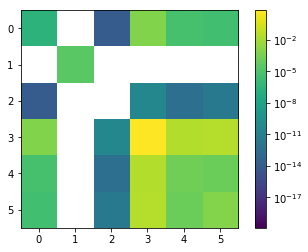

In [121]:
# Covariance matrix
cov_chain = np.genfromtxt("chain_ALLparam_run8.txt")[:,1:]

# These two give the same answer: np.cov() and dot(chain.T,chain)/len(chain)  [with mean subtracted]
cov = np.cov(cov_chain.T)
#meanchain=cov_chain-np.mean(cov_chain,axis=0)
#cov2 = np.dot(meanchain.T,meanchain)/len(cov_chain)


print(np.shape(cov))
print(cov)


from matplotlib.colors import LogNorm

plt.imshow(cov,norm=LogNorm())
plt.colorbar()

#divide by sqrt(diagonal) of product of diag elements... should match the np.corrcoef result


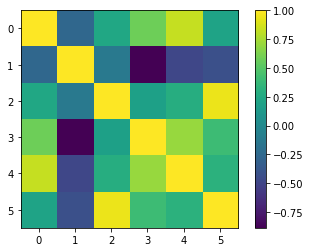

In [122]:
cov2=np.corrcoef(cov_chain.T)
plt.imshow(cov2)
plt.colorbar()

In [123]:
def check_cov_step(mat,nset=1):
    #if you work through the math, you need
    #to scale gaussian noise by the square root of the eigenvalues
    #then multiply by the eigenvectors.  Note that eigh assumes
    #input matrix is symmetric, and is more stable than eig for our purposes.
    #also, if we want to simulate many sets of data, there's no point finding
    #the eigenvalues/eigenvectors lots of times.  Let nset be the number of simulated datasets you want
    e,v=np.linalg.eigh(mat)
    e[e<0]=0 #make sure we don't have any negative eigenvalues due to roundoff
    n=len(e)
    #make gaussian random variables
    g=np.random.randn(n,nset)
    #now scale them by the square root of the eigenvalues
    rte=np.sqrt(e)
    for i in range(nset):
        g[:,i]=g[:,i]*rte
    #and rotate back into the original space
    dat=np.dot(v,g)
    return dat






nset=10000
#mat=np.ones([n,n])+np.eye(n) #make the noise matrix that is one everywhere but 2 along diagonal
mat= cov

dat=check_cov_step(mat,nset=nset)

mat_sim=np.dot(dat,dat.transpose())/nset
print('RMS error is ',np.std(mat-mat_sim))

print(dat)




RMS error is  0.017756356408748737
[[ 5.40073456e-04 -7.24575703e-05  2.33713508e-04 ... -7.57249332e-04
  -4.90115582e-04  2.52875308e-04]
 [-9.76038039e-04  2.09862223e-03 -3.20493810e-03 ...  5.69258975e-03
   9.42134929e-03 -4.69340425e-03]
 [-1.31382370e-10  1.75292517e-11  9.57940544e-11 ... -2.21834182e-10
  -7.08741702e-11  7.52203114e-11]
 [ 1.95667160e+00 -5.99468529e-01  3.47179108e-01 ... -5.37245842e+00
  -4.90080081e+00  2.52051512e+00]
 [ 1.36750164e-02 -1.00343885e-02  1.41720295e-02 ... -1.86117931e-02
  -2.27544716e-02  5.19400949e-03]
 [-3.44884181e-02  2.45236223e-03  2.71139043e-02 ... -5.95746412e-02
  -2.97140388e-02  2.60208333e-02]]


every instance of 'dat' is a random draw of steps for the 6 parameters

6


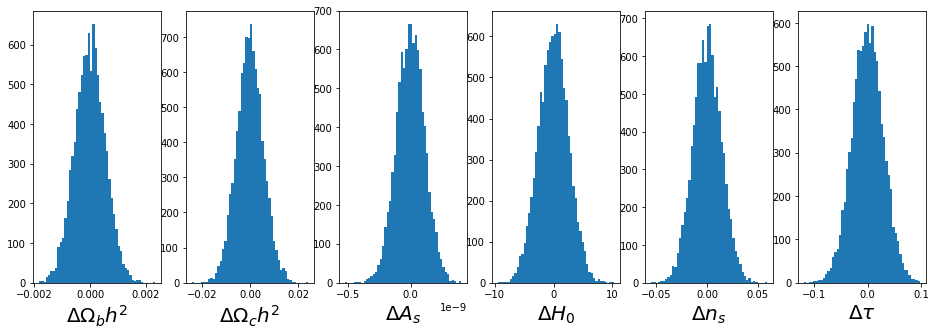

In [127]:
step_names=[r"$\Delta \Omega_b h^2$",r"$\Delta \Omega_c h^2$", "$\Delta A_s$", "$\Delta H_0$", "$\Delta n_s$", r"$\Delta \tau$", r"$\Delta a_{src}$"]

n = len(dat[:,0])

plt.figure(figsize=(16,5))
plt.clf()
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.hist(dat[i,:],bins=50)
    plt.xlabel(step_names[i],fontsize=20)

As far as I can tell, this is creating steps with the same kind of correlation as the run8 chain parameters.

See corner plot of steps below:

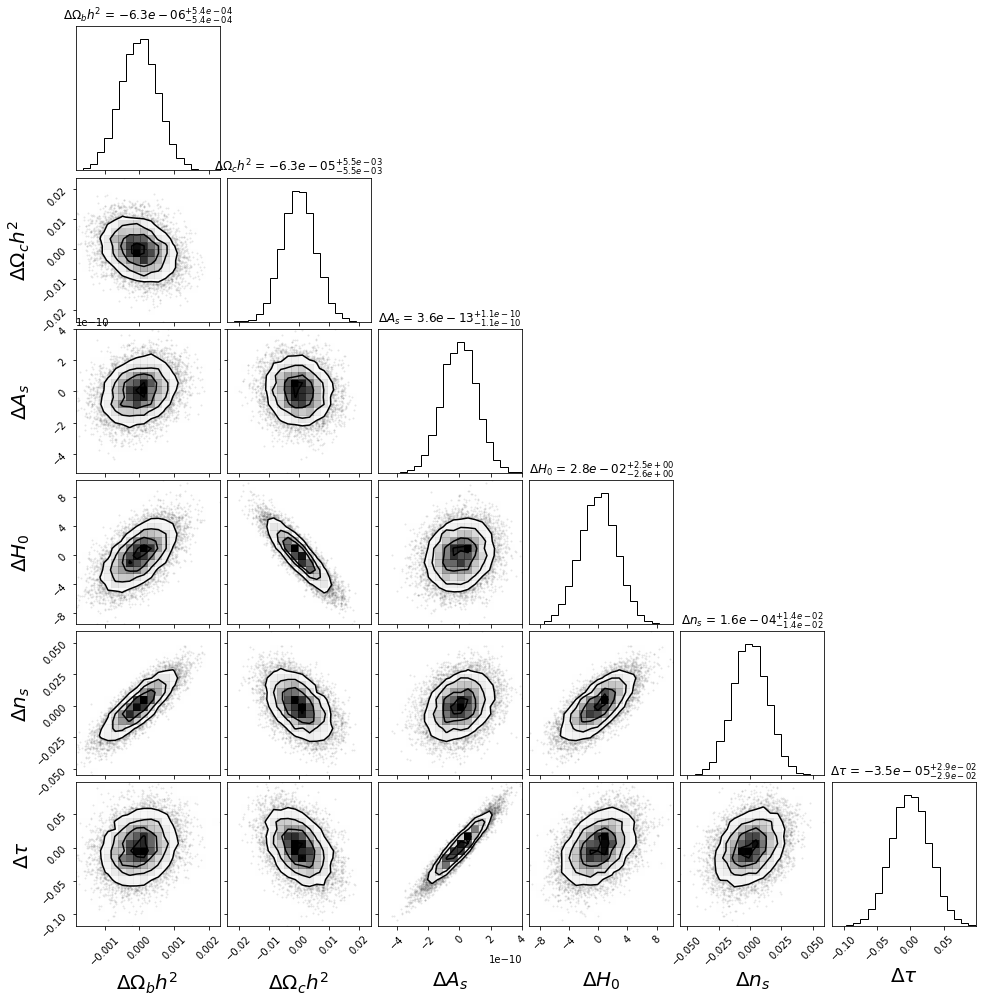

In [128]:
cornerplot = cp.corner(dat.T,
                       labels=step_names, label_kwargs={"fontsize": 20},
                       title_fmt='.1e',
                       show_titles=True, title_kwargs={"fontsize": 12} )

plt.savefig("figures/step_covariance.png")

In [91]:
# recover the typical uncertainty size for each param
cov_steps=np.zeros(len(step_names))
for i in range(len(step_names)): # must be done once per variable
    q_16, q_50, q_84 = cp.quantile(dat.T[:,i], [0.16, 0.5, 0.84]) # your x is q_50
    dx_down, dx_up = q_50-q_16, q_84-q_50
    cov_steps[i]=np.mean((dx_up,dx_down))

print(cov_steps)
print(cov_steps/1.5)
print(cov_steps/2)

[5.46421873e-04 5.73597781e-03 3.21993850e-10 2.50163402e+00
 1.34075687e-02 2.14938581e-02 6.47389265e-05]
[3.64281249e-04 3.82398521e-03 2.14662567e-10 1.66775601e+00
 8.93837910e-03 1.43292387e-02 4.31592843e-05]
[2.73210936e-04 2.86798891e-03 1.60996925e-10 1.25081701e+00
 6.70378433e-03 1.07469291e-02 3.23694633e-05]
